# Se importa github

In [2]:
! git clone https://github.com/ANN-2019-2/evaluacion-deescobarc.git

Cloning into 'evaluacion-deescobarc'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 44 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [0]:
%cd /content/evaluacion-deescobarc
!git pull

/content/evaluacion-deescobarc
Already up to date.


# Librerías a utilizar

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error

#Pruebas GPU

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Se agregan todos los datos a un sólo dataframe

In [0]:
"""
Se agregan todos los archivos de excel a un sólo dataframe
Se recorren en un for los años respectivos
"""
data = pd.DataFrame()


for i in range(1995,2019):
  if i < 2000:
    data = data.append(pd.read_excel('evaluacion-deescobarc/datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(i)+'.xlsx',header = 3,index_col=0))
  elif i < 2016:
    data = data.append(pd.read_excel('evaluacion-deescobarc/datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(i)+'.xlsx',header = 2,index_col=0))
  else:
    data = data.append(pd.read_excel('evaluacion-deescobarc/datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(i)+'.xls',header = 2,index_col=0))



#data = pd.read_excel('evaluacion-deescobarc/datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(1995)+'.xlsx',header = 3,index_col=0)
#data = data.append(pd.read_excel('evaluacion-deescobarc/datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(1996)+'.xlsx',header = 3,index_col=0))
#data = data.append(pd.read_excel('evaluacion-deescobarc/datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(1997)+'.xlsx',header = 3,index_col=0))


# Se calcula el promedio diario y se verifica como están los datos

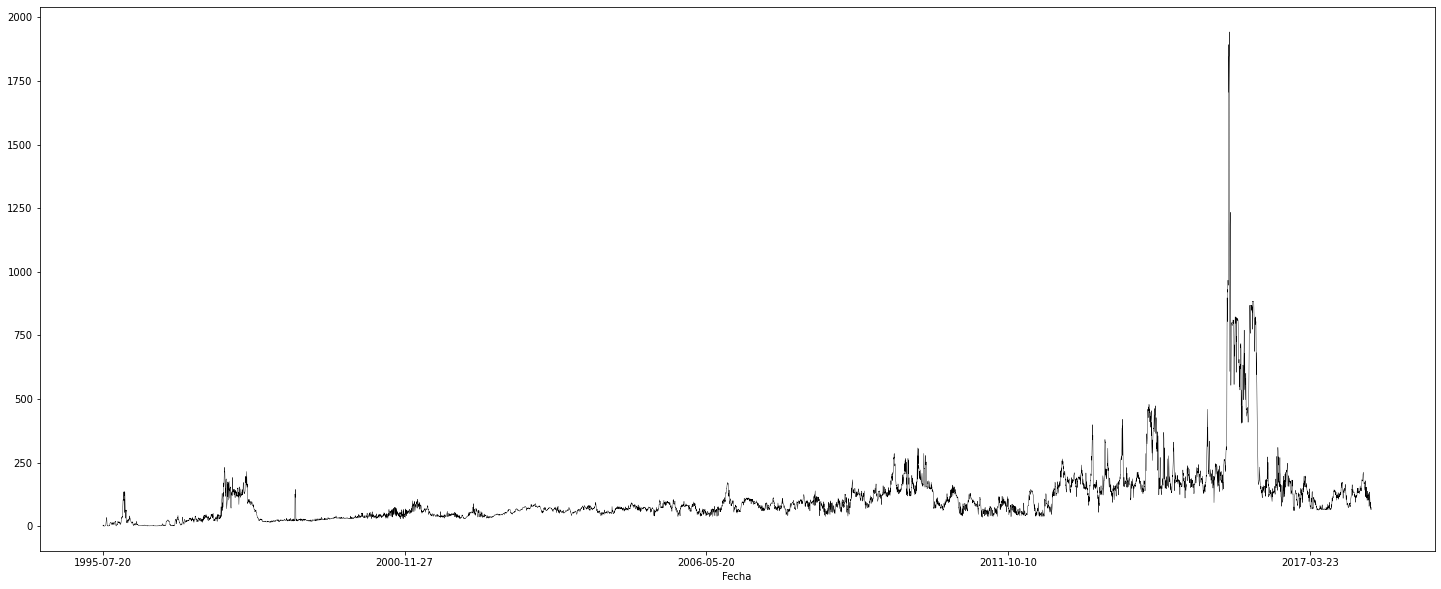

In [6]:
#Promedio diario de los precios
data_day = data.mean(axis=1)

data_day.plot(linewidth=.4, figsize=(25,10), color='black')
#data_day.plot(marker='.', alpha=0.4, linestyle='None',figsize=(10,10),subplots=True)


#Se pasa la moneda a constante y se verifica como quedan los datos

Se puede observar que se nota más la onda en los datos

           Fecha      Valor
0     1995-07-20   1.409435
1     1995-07-21   4.924333
2     1995-07-22   1.269500
3     1995-07-23   0.953083
4     1995-07-24   4.305917
...          ...        ...
8404  2018-05-01  15.126912
8405  2018-05-02  16.120583
8406  2018-05-03  15.017496
8407  2018-05-04  13.658560
8408  2018-05-05  15.613511

[8400 rows x 2 columns]
Valor    467.470226
dtype: float64


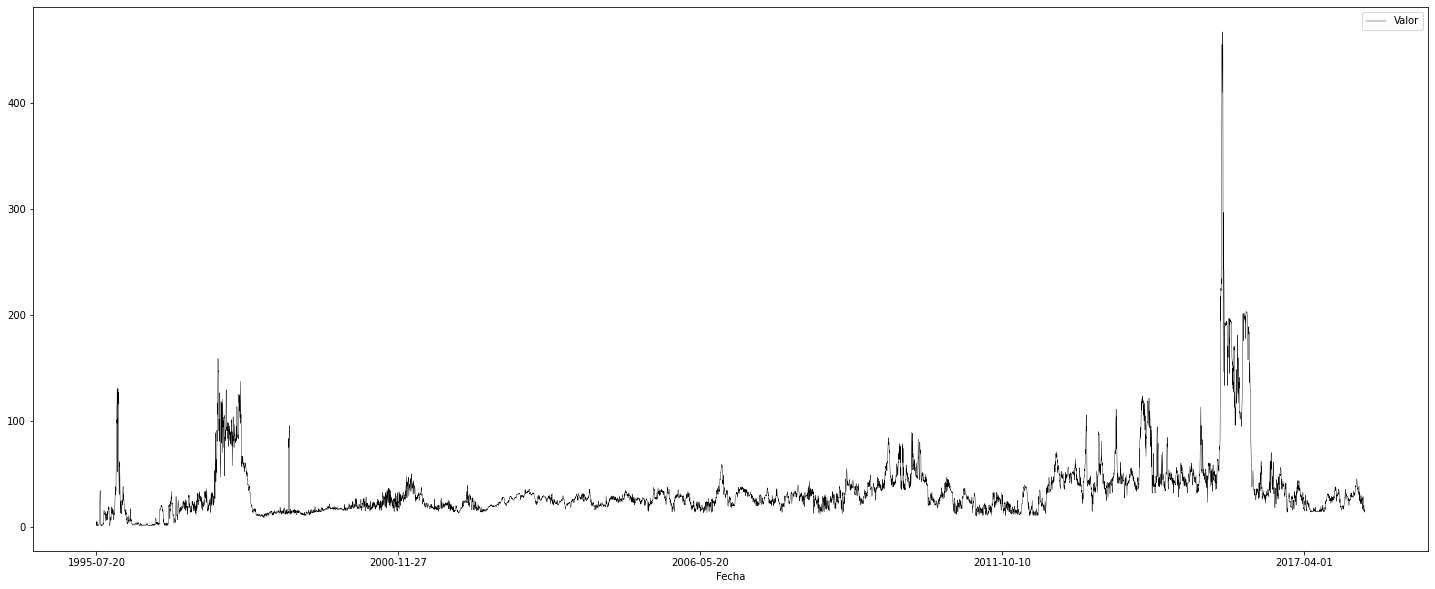

In [7]:
#Se sube el archivo del IPC
ipc = pd.read_excel(
    'evaluacion-deescobarc/datos/precios/1.2.5.IPC_Serie_variaciones.xlsx',
    header = 12,index_col=0, usecols=[0,1] ,nrows = 296, squeeze = True)

#Se recorre el archivo del IPC y se calcula el nuevo valor de la moneda
data_day_r = data_day.reset_index().dropna()
data_day_r.columns = ['Fecha', 'Valor']
separador = ""
for index, row in data_day_r.iterrows():
  fecha = list(str(row['Fecha']))
  year  = separador.join(fecha[0:4])
  month = separador.join(fecha[5:7])
  #Formula: Po * IPC/(IPC BASE)
  ipc_base = ipc.get(int('199507'))
  data_day_r.loc[index, 'Valor'] =  data_day_r.loc[index, 'Valor'] * (ipc_base / ipc.get(int(year+month)))

print(data_day_r)  
print(data_day_r.max(axis=0))
data_day_r.set_index('Fecha').plot(linewidth=.4, figsize=(25,10), color='black')


#Se realizan las transformaciones a los datos

Transformaciones cuadrada y logaritmo natural

Text(0.5, 1.0, 'Transformación Raíz Cúbica')

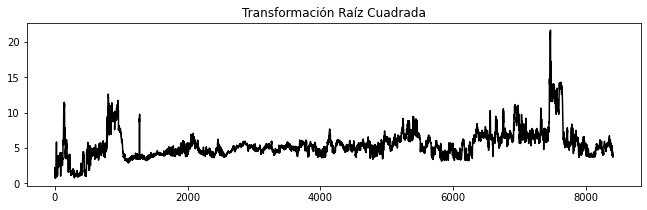

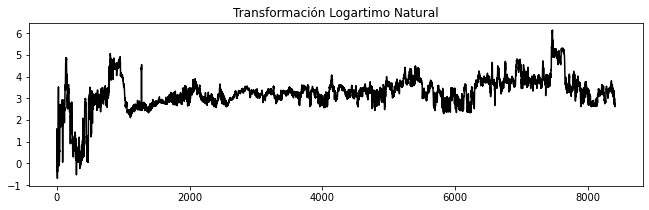

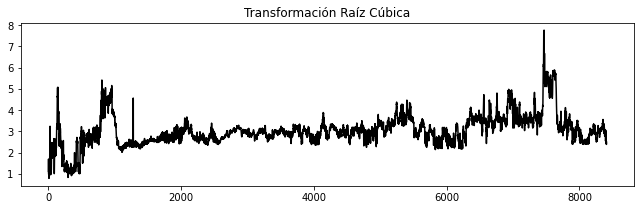

In [8]:
#Raíz Cuadrada
#d_raiz = sc.fit_transform(data_day_r["Valor"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)
d_raiz = data_day_r["Valor"].apply(np.sqrt)
#Logaritmo Natural
#d_log = sc.fit_transform(data_day_r["Valor"].apply(np.log).values.reshape(-1,1)).reshape(-1,)
d_log = data_day_r["Valor"].apply(np.log)
#Raíz Cúbica
#d_cubo = sc.fit_transform(data_day_r["Valor"].apply(lambda x: x**3).values.reshape(-1,1)).reshape(-1,)
d_cubo = data_day_r["Valor"].apply(lambda x : x**(1/3))

#Se grafica cada transformación
plt.figure(figsize=(11,3))
plt.plot(d_raiz, color='black');
plt.title('Transformación Raíz Cuadrada')

plt.figure(figsize=(11,3))
plt.plot(d_log, color='black');
plt.title('Transformación Logartimo Natural')

plt.figure(figsize=(11,3))
plt.plot(d_cubo, color='black');
plt.title('Transformación Raíz Cúbica')


#Volver a la original
#e = sc.inverse_transform(d.reshape(-1,1))

#plt.figure(figsize=(11,3))
#plt.plot(e, color='black');




#Se escalan los datos de todas las transformaciones a 0-1

In [0]:
#Escalar de 0 a 1 las transformaciones incluida la original
sc = MinMaxScaler(feature_range = (0, 1))
d = sc.fit_transform(data_day_r['Valor'].values.reshape(-1,1)).reshape(-1,)

sc_raiz = MinMaxScaler(feature_range = (0, 1))
draiz = sc_raiz.fit_transform(d_raiz.values.reshape(-1,1)).reshape(-1,)

sc_log = MinMaxScaler(feature_range = (0, 1))
dlog = sc_log.fit_transform(d_log.values.reshape(-1,1)).reshape(-1,)

sc_cubo = MinMaxScaler(feature_range = (0, 1))
dcubo = sc_cubo.fit_transform(d_cubo.values.reshape(-1,1)).reshape(-1,)

#Adaline con taza de aprendizaje y momentum

Se agregó al algoritmo visto en clase el momentum

In [0]:
class Adaline:
  def __init__(self,
                learning_rate=0.001, # tasa de aprendizaje
                momentum=0.8,        # Momentum
                max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                shuffle=False,       # mezcla patrones para aprendizaje online
                random_state=None,   #
                warm_start=False):   #                

    self.learning_rate = learning_rate
    self.momentum = momentum
    self.max_epochs = max_epochs
    self.shuffle = shuffle
    self.random_state = random_state
    self.warm_start = warm_start
    self.coef_ = None
    self.intercept_ = None

  def fit(self, X, y):

    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if not isinstance(y, np.ndarray):
        d = np.array(y)
    else:
        d = y.copy()

    if self.random_state is not None:
        np.random.RandomState(self.random_state)

    if self.coef_ is None or self.warm_start is False:
        self.coef_ = np.random.uniform(-1, 1, X.shape[1])

    if self.intercept_ is None  or self.warm_start is False:
        self.intercept_ = np.random.uniform(-1, 1, 1)

    errors2 = []
    forecasts = []
    #print(self.coef_ , self.intercept_)
    for epoch in range(self.max_epochs):

        if self.shuffle is True:
            n = list(range(X.shape[0]))
            np.random.shuffle(n)
            X = X[n,:]
            d = d[n]

        for i in range(X.shape[0]):
            u = np.dot(X[i,:], self.coef_) + self.intercept_
            e = (d[i] - u)[0]
            self.coef_ = (2 * self.learning_rate * e * X[i,:]) + (self.momentum * self.coef_) 
            self.intercept_ = (2 * self.learning_rate * e) + (self.momentum * self.intercept_) 
            
            errors2.append(e**2)
            forecasts.append(u)
    return errors2, forecasts

  def predict(self, X):
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    u = np.dot(X, self.coef_) + self.intercept_
    return u

#Número óptimo de retardos (observaciones)

Se crea una función que recibe el retardo y la serie de datos, lo que retorna la serie lista para el adaline

In [0]:

##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie (Retardos)
##  L = [5,6,7,8,9,10,11,12]
##
## Función generadora de matriz para el modelo
##
def matriz_x(l, d):
  X = []
  for t in range(l, len(d)):
    X.append(d[t-l:t].copy())
  return X

#Cálculo de valores óptimos de la tasa de aprendizaje y el momentum.

- Se crea una función que retorna un el modelo Adaline con u y b enviados
- La función calculo_tasa_momento recibe los datos preparados con el retardo y devuelve los valores óptimos de tasa de aprendizaje y momentum

In [0]:
#Función para cálcular los parámetros de tasa de aprendizaje y momentum ideales
def modelo_parametros(mu, b):
  adaline = Adaline(
    learning_rate=mu,  # tasa de aprendizaje
    momentum=b,        # Momentum
    max_epochs=1,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,    # corrida reproducible
    warm_start=False)    # inicia con pesos aleatorios

  return adaline

#d = d[L:]
#Se usaron dos mayas más para que el cálculo sea más exacto.
def calculo_tasa_momento(X, d, l): 
  tasa = 1
  momento = 1
  error = 1
  for i in np.arange(0, 1, 0.1):
    for j in np.arange(0, 1, 0.1):
      ad = modelo_parametros(i,j)
      errors2, forecasts = ad.fit(X,d[l:])
      e = sum(errors2)/len(errors2)
      if error > e:
        error = e
        tasa = i
        momento = j

  #Malla-1 para refinar
  for i in np.arange(tasa-0.1, tasa+0.1, 0.01):
    for j in np.arange(momento-0.1, momento+0.1, 0.01):
      ad = modelo_parametros(i,j)
      errors2, forecasts = ad.fit(X,d[l:])
      e = sum(errors2)/len(errors2)
      if error > e:
        error = e
        tasa = i
        momento = j

  #Malla-2 para refinar
  for i in np.arange(tasa-0.01, tasa+0.01, 0.001):
    for j in np.arange(momento-0.01, momento+0.01, 0.001):
      ad = modelo_parametros(i,j)
      errors2, forecasts = ad.fit(X,d[l:])
      e = sum(errors2)/len(errors2)
      if error > e:
        error = e
        tasa = i
        momento = j

  return tasa, momento






#Se realiza el pronóstico para cada transformación

##Sin transformación

In [0]:
L = [5,6,7,8,9,10,11,12]
#Sin ninguna transformación
mse = []
for l in L:
  #Se obtiene la matriz con el retardo respectivo
  X = matriz_x(l,d)
  #Se encuentra los valores óptimos de tasa y momento
  tasa, momento = calculo_tasa_momento(X, d, l)
  #Se crea una instancia de adaline con los parámetros encontrados
  adl = modelo_parametros(tasa, momento)
  #Se entrena el adaline y se obtiene el pronóstico
  errors2, pronostico = adl.fit(X,d[l:])

  #Se realiza la transformación inversa de la escala
  pr = sc.inverse_transform(np.array(pronostico))

  #Se cálcula el error y se guarda en un arreglo
  mse.append(mean_squared_error(np.array(data_day_r['Valor'])[l:], pr))

##Raíz cuadrada

In [0]:
mse_raiz = []
for l in L:
  #Se obtiene la matriz con el retardo respectivo
  X = matriz_x(l,draiz)
  #Se encuentra los valores óptimos de tasa y momento
  tasa, momento = calculo_tasa_momento(X, draiz, l)
  #Se crea una instancia de adaline con los parámetros encontrados
  adl = modelo_parametros(tasa, momento)
  #Se entrena el adaline y se obtiene el pronóstico
  errors2, pronostico = adl.fit(X,draiz[l:])

  #Se realiza la transformación inversa de la escala
  pr = sc_raiz.inverse_transform(np.array(pronostico))

  #Se realiza la transformación inversa de la raíz
  pr_inv = pd.Series(pr.reshape(-1)).apply(lambda x : x**2)

  #Se cálcula el error y se guarda en un arreglo
  mse_raiz.append(mean_squared_error(np.array(data_day_r['Valor'])[l:], np.array(pr_inv)))

##Logaritmo Natural

In [0]:
mse_log = []
for l in L:
  #Se obtiene la matriz con el retardo respectivo
  X = matriz_x(l,dlog)
  #Se encuentra los valores óptimos de tasa y momento
  tasa, momento = calculo_tasa_momento(X, dlog, l)
  #Se crea una instancia de adaline con los parámetros encontrados
  adl = modelo_parametros(tasa, momento)
  #Se entrena el adaline y se obtiene el pronóstico
  errors2, pronostico = adl.fit(X,dlog[l:])

  #Se realiza la transformación inversa de la escala
  pr = sc_log.inverse_transform(np.array(pronostico))

  #Se realiza la transformación inversa del logaritmo
  pr_inv = pd.Series(pr.reshape(-1)).apply(lambda x : math.e**x)

  #Se cálcula el error y se guarda en un arreglo
  mse_log.append(mean_squared_error(np.array(data_day_r['Valor'])[l:], np.array(pr_inv)))


##Raíz Cúbica

In [0]:
mse_cubo = []
for l in L:
  #Se obtiene la matriz con el retardo respectivo
  X = matriz_x(l,dcubo)
  #Se encuentra los valores óptimos de tasa y momento
  tasa, momento = calculo_tasa_momento(X, dcubo, l)
  #Se crea una instancia de adaline con los parámetros encontrados
  adl = modelo_parametros(tasa, momento)
  #Se entrena el adaline y se obtiene el pronóstico
  errors2, pronostico = adl.fit(X,dcubo[l:])

  #Se realiza la transformación inversa de la escala
  pr = sc_cubo.inverse_transform(np.array(pronostico))

  #Se realiza la transformación inversa del logaritmo
  pr_inv = pd.Series(pr.reshape(-1)).apply(lambda x : x**3)

  #Se cálcula el error y se guarda en un arreglo
  mse_cubo.append(mean_squared_error(np.array(data_day_r['Valor'])[l:], np.array(pr_inv)))

#Validación de los modelos 

[43.948297485483764, 70.48702178454097, 100.027397423126, 48.40108596489483, 86.8189262759101, 51.74261703955716, 69.31647930796844, 83.07616643731028] [43.34431295909986, 44.07363105412062, 44.946400221389005, 42.65256753938588, 79.0682939611739, 43.88953375298733, 42.6382952190588, 47.03075052397402] [49.580131577452605, 41.779226852672394, 49.744616794531524, 43.098355418678544, 52.2294839275084, 46.626673200911725, 48.52873037495317, 70.45170550007829] [38.90113666191053, 41.700625748331056, 49.96147881177541, 39.614550314739006, 43.12795917394452, 42.3684782097452, 47.136573682269905, 47.84301146240958]


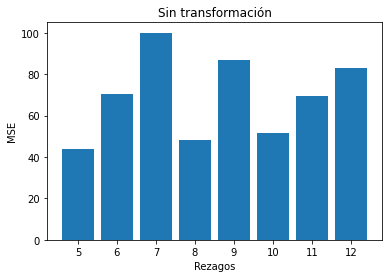

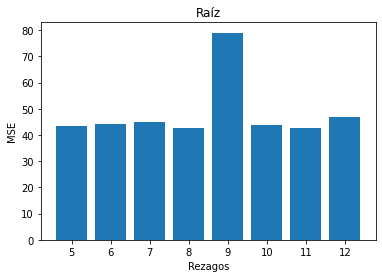

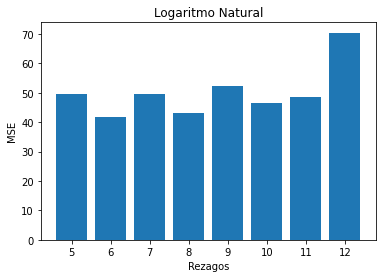

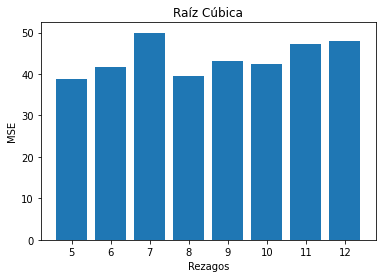

In [40]:
print(mse, mse_raiz, mse_log,mse_cubo)
l_label = ["5","6","7","8","9","10","11","12"]

plt.bar(l_label,mse)
plt.title("Sin transformación")
plt.xlabel("Rezagos")
plt.ylabel("MSE")
plt.show()

plt.bar(l_label,mse_raiz)
plt.title("Raíz")
plt.xlabel("Rezagos")
plt.ylabel("MSE")
plt.show()

plt.bar(l_label,mse_log)
plt.title("Logaritmo Natural")
plt.xlabel("Rezagos")
plt.ylabel("MSE")
plt.show()

plt.bar(l_label,mse_cubo)
plt.title("Raíz Cúbica")
plt.xlabel("Rezagos")
plt.ylabel("MSE")
plt.show()

#Error mínimo de cada transformación

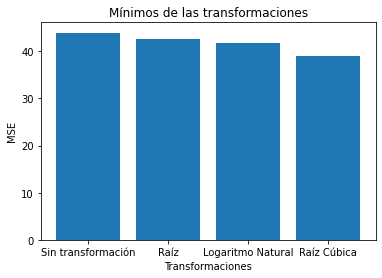

In [44]:
minimos = []
minimos.append(np.array(mse).min())
minimos.append(np.array(mse_raiz).min())
minimos.append(np.array(mse_log).min())
minimos.append(np.array(mse_cubo).min())

tr_label = ["Sin transformación", "Raíz", "Logaritmo Natural", "Raíz Cúbica"]

plt.bar(tr_label,minimos)
plt.title("Mínimos de las transformaciones")
plt.xlabel("Transformaciones")
plt.ylabel("MSE")
plt.show()

#Elección del modelo

El menor MSE es el de la raíz cúbica con 5 retardos

In [0]:
mse_cubo = []
#Se obtiene la matriz con el retardo respectivo
X = matriz_x(5,dcubo)

#Se encuentra los valores óptimos de tasa y momento
tasa, momento = calculo_tasa_momento(X, dcubo, 5)

#Se crea una instancia de adaline con los parámetros encontrados
adl = modelo_parametros(tasa, momento)

#Se entrena el adaline y se obtiene el pronóstico
errors2, pronostico = adl.fit(X,dcubo[5:])

#Se realiza la transformación inversa de la escala
pr = sc_cubo.inverse_transform(np.array(pronostico))

#Se realiza la transformación inversa del logaritmo
pr_inv = pd.Series(pr.reshape(-1)).apply(lambda x : x**3)


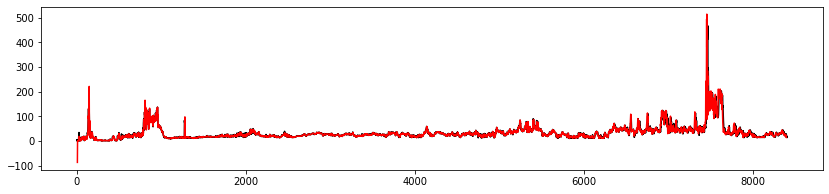

In [47]:
plt.figure(figsize=(14,3))
plt.plot(data_day_r['Valor'], color='black');
plt.plot(range(5,len(d)), pr_inv, color = 'red');